In [1]:
# Read daily files
import glob, pandas as pd
files = glob.glob("Downloads/2023/**/*.csv")

dfs = []

for file in files:
    print(file)
    df_file = pd.read_csv(file, sep=",", index_col=None, header=0)
    dfs.append(df_file)

df = pd.concat(dfs, axis=0, ignore_index=True)

Downloads/2023\07\2023-07-06.csv
Downloads/2023\07\2023-07-07.csv
Downloads/2023\07\2023-07-08.csv
Downloads/2023\07\2023-07-09.csv
Downloads/2023\07\2023-07-10.csv
Downloads/2023\07\2023-07-11.csv
Downloads/2023\07\2023-07-12.csv
Downloads/2023\07\2023-07-13.csv
Downloads/2023\07\2023-07-14.csv
Downloads/2023\07\2023-07-15.csv
Downloads/2023\07\2023-07-16.csv
Downloads/2023\07\2023-07-17.csv
Downloads/2023\07\2023-07-18.csv
Downloads/2023\07\2023-07-19.csv
Downloads/2023\07\2023-07-20.csv
Downloads/2023\07\2023-07-21.csv
Downloads/2023\07\2023-07-22.csv
Downloads/2023\07\2023-07-23.csv
Downloads/2023\07\2023-07-24.csv
Downloads/2023\07\2023-07-25.csv
Downloads/2023\07\2023-07-26.csv
Downloads/2023\07\2023-07-27.csv
Downloads/2023\07\2023-07-28.csv
Downloads/2023\07\2023-07-29.csv
Downloads/2023\07\2023-07-30.csv
Downloads/2023\07\2023-07-31.csv
Downloads/2023\08\2023-08-01.csv
Downloads/2023\08\2023-08-02.csv
Downloads/2023\08\2023-08-03.csv
Downloads/2023\08\2023-08-04.csv
Downloads/

In [2]:
df_keys = \
    df[["Hwsku", "Tenant", "Region"]]\
    .drop_duplicates()\
    .reset_index()

In [3]:
IN_STEPS, OUT_STEPS = 168, 168

In [16]:
# Plotting function

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf

def plot_figure(values, labels, titles, use_subplots=True):
    plt.figure(figsize=(12,5), dpi=100)

    if use_subplots and len(values) > 1:
        fig, axes = plt.subplots(len(values), 1, sharex=True)
    
        for i in range(len(values)):
            axes[i].plot(values[i], label=labels[i])
            axes[i].set_title(titles[i])
            axes[i].legend(loc='upper left', fontsize=8)
    else:
        for i in range(len(values)):
            plt.plot(values[i], label=labels[i])
            
        plt.title(titles[0])
        plt.legend(loc='upper left', fontsize=8)
        
    plt.show()

In [21]:
def create_dataset(data, input_steps=1, output_steps=1):
    Xs, Ys = [], []
    
    for i in range(len(data) - input_steps - output_steps):
        u = data.iloc[i:(i + input_steps)].values
        v = data.iloc[(i + input_steps):(i + input_steps + output_steps)].values
        Xs.append(u)        
        Ys.append(v)

    Xs = np.array(Xs)
    Xs = Xs.reshape(Xs.shape[0], Xs.shape[1], 1)

    Ys = np.array(Ys)
    Ys = Ys.reshape(Ys.shape[0], Ys.shape[1], 1)
    
    return Xs, Ys

In [22]:
def model_ts():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=4096, kernel_size=IN_STEPS, activation='relu', input_shape=(IN_STEPS, 1)))
    model.add(tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.001))

    return model

In [25]:
def do_process(df, hwsku, tenant, region):
    key = hwsku + "___" + tenant + "___" + region
    print(key)
    
    # Filter based on Hwsku, Tenant and Region
    print("Filtering based on key...")
    df_one = \
        df\
        [\
            (df.Hwsku == hwsku)&\
            (df.Tenant == tenant)&\
            (df.Region == region)\
        ].reset_index()

    if len(df_one) < 1000:
        return

    # Select SnapshotTime and PhysicalCores
    df_filt = df_one[["SnapshotTime", "PhysicalCores"]].copy()
    df_filt.rename(columns={"PhysicalCores":"cores"}, inplace=True)

    # Replace NULL with 0 values for PhysicalCores
    df_filt.fillna(0, inplace=True)

    plot_figure([df_filt.cores], ["num_cores"], ["Physical Cores"])

    # Do FFT transform of the values to get the period of the series
    print("Doing FFT Transform for period calculation...")
    fft = np.fft.rfft(df_filt.cores)

    plot_figure([abs(fft)[1:]], ["frequency"], ["FFT Transform"])

    # Find period of series from FFT transformation
    # period of the data is around 168 = 24*7, the values have a weekly
    # cycle and since the data is 1hr window, thus period in number of hours = 7*24 = 168
    
    periods = np.argsort(abs(fft))[::-1][:10]
    period = [p for p in periods if p > 0][0]
    period = int(len(df_filt)/period)+1
    print(period)

    # Decompose time series into trend, seasonal and residual components
    print("Doing time series decomposition...")
    result = seasonal_decompose(df_filt.cores, 
                                model='additive', 
                                extrapolate_trend='freq', 
                                period=168)
    print(result.trend)
    print(result.seasonal)
    print(result.resid)
    print(result.observed)

    # Plot decomposed time series

    plot_figure([result.trend, result.seasonal, result.resid], 
            ["trend", "seasonality", "residual"], 
            ["Trend", "Seasonality", "Residual"])

    # Perform anomaly detection on residual series.
    # Here we are using the Isolation Forest algorithm

    print("Doing anomaly detection on residuals...")
    
    anomaly_data = [[x] for x in result.resid]
    clf = IsolationForest(random_state=0).fit(anomaly_data)
    out = clf.predict(anomaly_data)

    # Replace anomaly values with moving average of last 24 hours

    print("Replacing anomalies with last 24 hrs MA...")
    
    anomaly_indices = [i for i in range(len(out)) if out[i] == -1]
    anomaly_indices_prev = [[max(0,i-24), max(0,i-1)] for i in anomaly_indices]
    prev_averages = [df_filt["cores"].loc[x:y].mean() for x, y in anomaly_indices_prev]

    df_filt.loc[anomaly_indices, "cores"] = prev_averages

    plot_figure([df_filt.cores], ["num_cores"], ["Physical Cores"])

    # Create Training and Test
    print("Creating train test data...")
    
    n = int(0.9*len(df_filt))
    train = df_filt.cores[:n]
    test = df_filt.cores[n:]

    train_mean = train.mean()
    train_std = train.std()
    
    train = (train - train_mean) / train_std

    X_train, y_train = create_dataset(train, IN_STEPS, OUT_STEPS)

    print("Training model...")
    model = model_ts()

    history = \
        model.fit(\
                X_train, 
                y_train, 
                epochs=100, 
                batch_size=32, 
                validation_split=None, 
                verbose=1, 
                shuffle=False
               )

    print("Doing prediction on test data...")
    u = train.iloc[-IN_STEPS:].values
    u = np.array(u).reshape(1, IN_STEPS, 1)
    v = model.predict(u)
    v = v[0]*train_std+train_mean
    v = v.reshape(1, v.shape[0])

    plot_figure([test.tolist(), v[0].tolist()], 
                ["actual", "forecast"], 
                ["Forecast vs Actuals"], 
                use_subplots=False)

intel_lm_mm___tyo22prdapp29___japaneast
Filtering based on key...


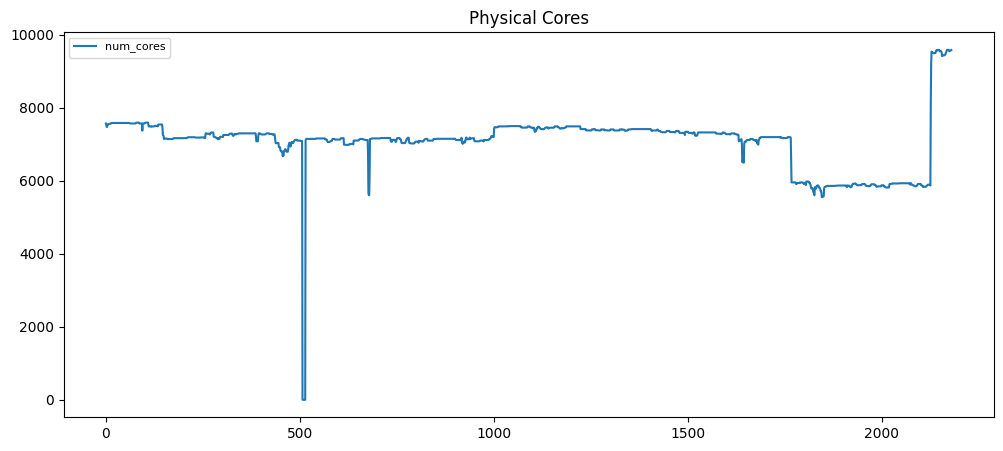

Doing FFT Transform for period calculation...


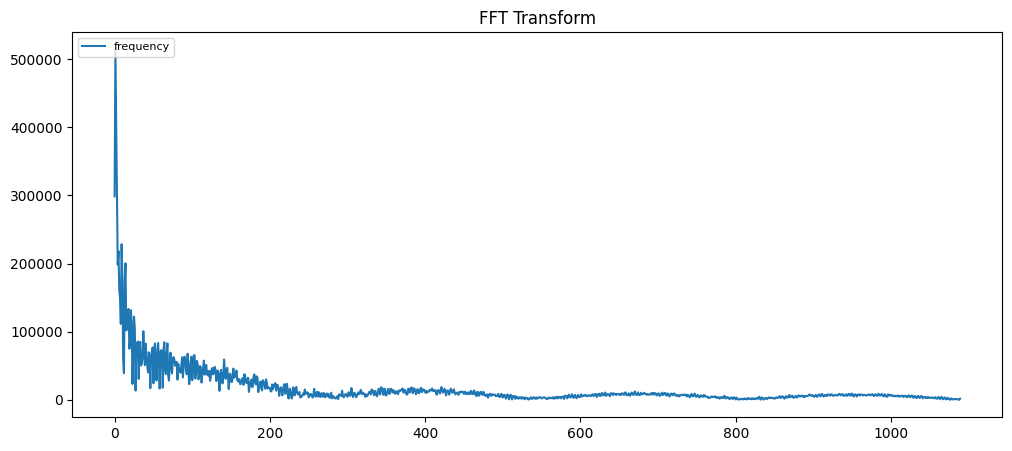

1091
Doing time series decomposition...
0       7655.141162
1       7653.171735
2       7651.202308
3       7649.232882
4       7647.263455
           ...     
2176    6911.520168
2177    6916.676444
2178    6921.832720
2179    6926.988995
2180    6932.145271
Name: trend, Length: 2181, dtype: float64
0       -66.762118
1       -62.976740
2       -72.647875
3      -606.333732
4      -603.310167
           ...    
2176    148.137812
2177    163.501524
2178    165.102624
2179    157.850901
2180    160.995993
Name: seasonal, Length: 2181, dtype: float64
0        -16.918206
1        -64.633321
2        -93.913750
3        431.962664
4        491.005986
           ...     
2176    2500.381737
2177    2486.079226
2178    2480.012313
2179    2493.852251
2180    2491.015099
Name: resid, Length: 2181, dtype: float64
0       7571.460837
1       7525.561675
2       7484.640684
3       7474.861813
4       7534.959274
           ...     
2176    9560.039717
2177    9566.257194
2178    9566.947657
21

<Figure size 1200x500 with 0 Axes>

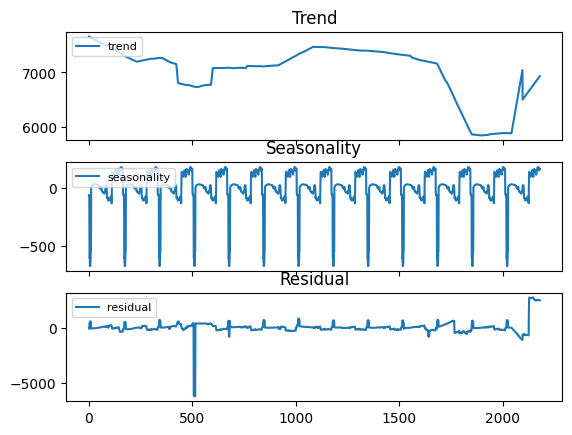

Doing anomaly detection on residuals...
Replacing anomalies with last 24 hrs MA...


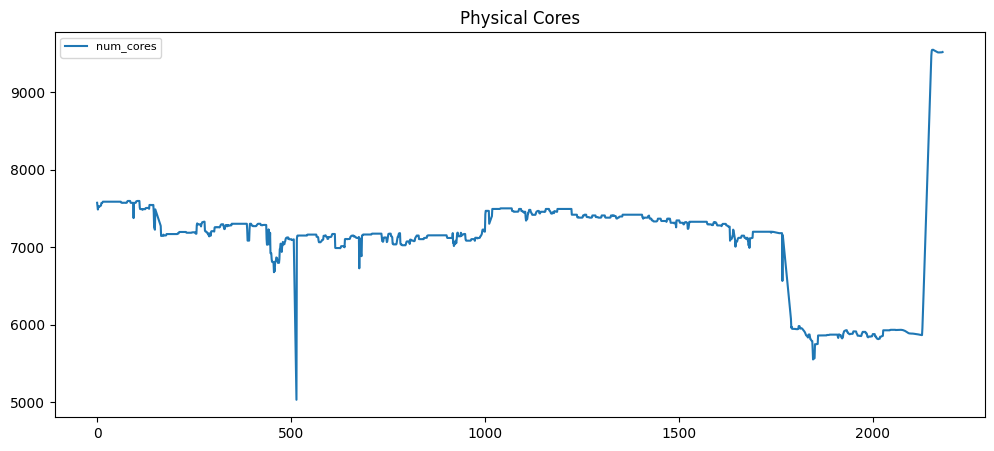

Creating train test data...
Training model...
Epoch 1/100
51/51 [==============================] - 1s 10ms/step - loss: 0.7912
Epoch 2/100
51/51 [==============================] - 0s 10ms/step - loss: 1.9981
Epoch 3/100
51/51 [==============================] - 0s 10ms/step - loss: 0.9046
Epoch 4/100
51/51 [==============================] - 0s 9ms/step - loss: 1.4695
Epoch 5/100
51/51 [==============================] - 0s 9ms/step - loss: 2.8269
Epoch 6/100
51/51 [==============================] - 0s 9ms/step - loss: 1.1361
Epoch 7/100
51/51 [==============================] - 1s 10ms/step - loss: 1.6432
Epoch 8/100
51/51 [==============================] - 0s 10ms/step - loss: 2.2596
Epoch 9/100
51/51 [==============================] - 0s 9ms/step - loss: 0.9046
Epoch 10/100
51/51 [==============================] - 0s 9ms/step - loss: 0.6238
Epoch 11/100
51/51 [==============================] - 0s 9ms/step - loss: 0.5474
Epoch 12/100
51/51 [==============================] - 0s 9ms/step -

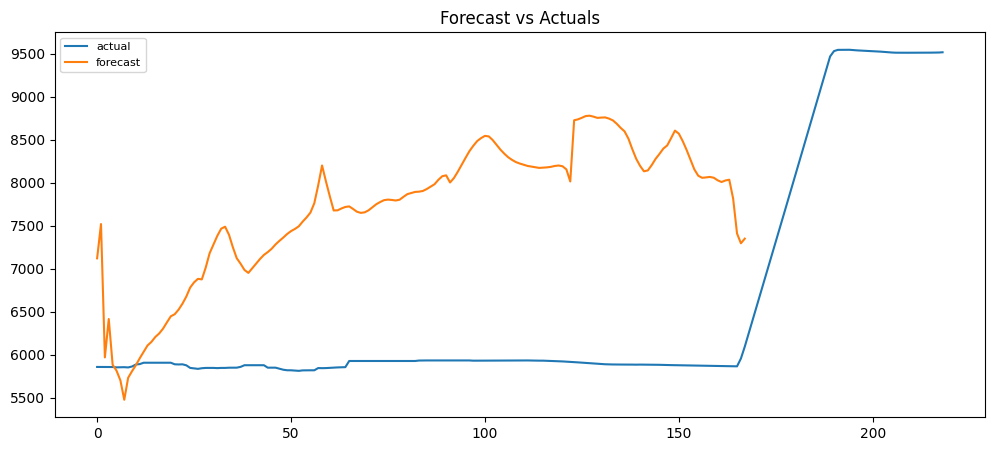

In [26]:
for i in range(len(df_keys)):
    _, hwsku, tenant, region = list(df_keys.loc[i])
    do_process(df, hwsku, tenant, region)
    break

In [ ]:
# Filter based on Hwsku, Tenant and Region
df_one = \
    df\
    [\
        (df.Hwsku == "intel_all")&\
        (df.Tenant == "mnz26prdapp03")&\
        (df.Region == "useast")\
    ].reset_index()

In [ ]:
df_one

In [ ]:
# Select SnapshotTime and PhysicalCores
df_filt = df_one[["SnapshotTime", "PhysicalCores"]].copy()
df_filt.rename(columns={"PhysicalCores":"cores"}, inplace=True)

In [ ]:
# Replace NULL with 0 values for PhysicalCores
df_filt.fillna(0, inplace=True)

In [ ]:
df_filt

In [ ]:
# Plotting function

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_figure(values, label, title):
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(values, label=label)
    plt.title(title)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [ ]:
plot_figure(df_filt.cores, "num_cores", "Physical Cores")

In [ ]:
# Do FFT transform of the values to get the period of the series
fft = np.fft.rfft(df_filt.cores)

In [ ]:
plot_figure(abs(fft)[1:], "frequency", "FFT Transform")

In [ ]:
# Find period of series from FFT transformation
# period of the data is around 168 = 24*7, the values have a weekly
# cycle and since the data is 1hr window, thus period in number of hours = 7*24 = 168

periods = np.argsort(abs(fft))[::-1][:10]
period = [p for p in periods if p > 0][0]
period = int(len(df_filt)/period)+1
print(period)

In [ ]:
# Decompose time series into trend, seasonal and residual components

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_filt.cores, 
                            model='additive', 
                            extrapolate_trend='freq', 
                            period=168)
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

In [ ]:
plot_figure([result.trend, result.seasonal, result.resid], 
            ["trend", "seasonality", "residual"], 
            ["Trend", "Seasonality", "Residual"])

In [ ]:
# Plot decomposed time series

plot_figure(result.trend, "trend", "Trend")
plot_figure(result.seasonal, "seasonality", "Seasonality")
plot_figure(result.resid, "residual", "Residual")

In [ ]:
# Perform anomaly detection on residual series.
# Here we are using the Isolation Forest algorithm

from sklearn.ensemble import IsolationForest
anomaly_data = [[x] for x in result.resid]
clf = IsolationForest(random_state=0).fit(anomaly_data)
out = clf.predict(anomaly_data)

In [ ]:
# import numpy as np
# x = np.percentile(result.resid, 10)
# y = np.percentile(result.resid, 90)
# out = [1 if (x-1.5*(y-x)) <= z <= (x+1.5*(y-x)) else -1 for z in result.resid]

In [ ]:
# Replace anomaly values with moving average of last 24 hours

anomaly_indices = [i for i in range(len(out)) if out[i] == -1]
anomaly_indices_prev = [[max(0,i-24), max(0,i-1)] for i in anomaly_indices]
prev_averages = [df_filt["cores"].loc[x:y].mean() for x, y in anomaly_indices_prev]

In [ ]:
df_filt.loc[anomaly_indices, "cores"] = prev_averages

In [ ]:
plot_figure(df_filt.cores, "num_cores", "Physical Cores")

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(df_filt.cores.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_filt.cores); axes[0, 0].set_title('Original Series')
plot_acf(df_filt.cores, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_filt.cores.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_filt.cores.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_filt.cores.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_filt.cores.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_filt.cores.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_filt.cores.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_filt.cores.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_filt.cores.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
n = int(0.9*len(df_filt))
train = df_filt.cores[:n]
test = df_filt.cores[n:]

In [ ]:
train

In [ ]:
test

In [ ]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, 
                       start_p=0, 
                       start_q=0, 
                       test='adf', 
                       max_p=3, 
                       max_q=3, 
                       m=168, 
                       start_P=0, 
                       max_P=3, 
                       start_Q=0, 
                       max_Q=3, 
                       max_D=3, 
                       seasonal=True, 
                       d=1, 
                       D=1, 
                       trace=True, 
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

In [ ]:
preds = smodel.predict(val.shape[0])

In [ ]:
forecast_accuracy(preds, val.values)

In [ ]:
# Forecast
# Make as pandas series
fc_series = pd.Series(preds, index=val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(val, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, test_df,
               label_columns=None):
      
    # Store the raw data.
    self.train_df = train_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='cores', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def _train(self):
  return self.make_dataset(self.train_df)

@property
def _val(self):
  return self.make_dataset(self.val_df)

@property
def _test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self._train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator._train = _train
WindowGenerator._val = _val
WindowGenerator._test = _test
WindowGenerator.example = example

In [ ]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window._train, epochs=MAX_EPOCHS)
  return history

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

IN_STEPS = test.shape[0]
OUT_STEPS = test.shape[0]

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(1)

def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

In [ ]:
CONV_WIDTH = IN_STEPS
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(4096, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

In [ ]:
train_df=pd.DataFrame(train)
test_df=pd.DataFrame(test)

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
w1 = WindowGenerator(input_width=IN_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS, train_df=train_df, test_df=test_df, label_columns=['cores'])
w1

In [ ]:
history = compile_and_fit(multi_conv_model, w1)

In [ ]:
h = w1.make_dataset(pd.concat([w1.train_df[-IN_STEPS:], w1.test_df]))
preds = multi_conv_model.predict(h)

In [ ]:
w1.plot(multi_conv_model)

In [ ]:
preds2 = preds[0]*train_std[0]+train_mean[0]

In [ ]:
preds2 = preds2.reshape(1,OUT_STEPS)[0]

In [ ]:
preds2

In [ ]:
# Forecast

# Make as pandas series
fc_series = pd.Series(preds2, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
train

In [ ]:
def create_dataset(X, input_steps=1, output_steps=1):
    Xs, ys = [], []
    
    for i in range(len(X) - input_steps - output_steps):
        u = X.iloc[i:(i + input_steps)].values
        v = X.iloc[(i + input_steps):(i + input_steps + output_steps)].values
        Xs.append(u)        
        ys.append(v)

    Xs = np.array(Xs)
    Xs = Xs.reshape(Xs.shape[0], Xs.shape[1], 1)

    Ys = np.array(Ys)
    Ys = Xs.reshape(Ys.shape[0], Ys.shape[1], 1)
    
    return Xs, Ys

In [ ]:
train_df=pd.DataFrame(train)

train_mean = train_df.mean()
train_std = train_df.std()

In [ ]:
(train - train_mean[0]) / train_std[0]

In [ ]:
train_df=pd.DataFrame(train)

train_mean = train_df.mean()
train_std = train_df.std()

train = (train - train_mean[0]) / train_std[0]

In [ ]:
train

In [ ]:
X_train, y_train = create_dataset(train, IN_STEPS, OUT_STEPS)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [ ]:
X_train

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters=4096, kernel_size=IN_STEPS, activation='relu', input_shape=(IN_STEPS, 1)))
model.add(tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.001))

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=None, 
    verbose=1, 
    shuffle=False
)

In [ ]:
u = train.iloc[-IN_STEPS:].values

In [ ]:
u

In [ ]:
u = np.array(u).reshape(1, IN_STEPS, 1)

In [ ]:
v = model.predict(u)

In [ ]:
v = v[0]*train_std[0]+train_mean[0]

In [ ]:
v = v.reshape(1, v.shape[0])

In [ ]:
v[0].tolist()

In [ ]:
# Forecast

# Make as pandas series

# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train, label='training')
plt.plot(test.tolist(), label='actual')
plt.plot(v[0].tolist(), label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()